In [1]:
# In this script, we will read in the surface air temp from CMIP5 output,
# calculate the change in SAT relative to the control,
# and spatially plot it.

# By: Ty Janoski
# updated: 08.17.20

In [2]:
# Import statements

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [3]:
diff_list = []
# read in CAM5 kernel for lat/lon grid
ds_ker = xr.open_dataset('/dx05/tylerj/d10/Arctic_Research/'+
                         'CMIP5_Arctic_Amplification/'+
                         'CAM5_kernels/alb.kernel.nc',decode_times=False)
lats = ds_ker.lat
lons = ds_ker.lon

del ds_ker

# # make empty dataset with lat/lon for regridding later on
# ds_out = xr.Dataset({'lat': (['lat'], lats),
#                      'lon': (['lon'], lons),
#                     }
#                    )

# make empty dataset with lat/lon for regridding later on
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90,91,1)),
                     'lon': (['lon'], np.arange(0,361,1)),
                    }
                   )

models = ['ACCESS1-0','ACCESS1-3','CNRM-CM5','IPSL-CM5B-LR','GFDL-ESM2G',
         'MIROC-ESM', 'FGOALS-g2', 'bcc-csm1-1','BNU-ESM','CanESM2','CCSM4',
          'CSIRO-Mk3-6-0','FGOALS-s2','GFDL-CM3','inmcm4',
         'IPSL-CM5A-LR','MIROC5','MPI-ESM-LR','MPI-ESM-P','MRI-CGCM3','NorESM1-M']
glb_list = []
arc_list = []
for mod in models:
    print(mod)
    
    # read in last 50 years of piControl
    picontrol = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/piControl/tas_Amon_'+mod+'_*.nc',
                              parallel=True,combine='by_coords',use_cftime=True).tas.isel(time=
                                                                          slice(-600,None))

    # make monthly climatology
    clim = picontrol.groupby(picontrol.time.dt.month).mean(dim='time')

    # read in first 150 years of abrupt4xCO2
    abr = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/abrupt4xCO2/tas_Amon_'+mod+'_*.nc',
                                  parallel=True,combine='by_coords',use_cftime=True).tas.isel(time=
                                                                              slice(None,1800))

    # calculate difference between abrupt4xCO2 and clim (clim must be tiled to be 150 years long)
    diff = abr - np.tile(clim,(150,1,1))
    
    # regrid to common grid (which I'm arbitrarily making the CAM5 grid)
    regridder = xe.Regridder(diff,ds_out,'bilinear',periodic=True,reuse_weights=True)
    
    diffrg = regridder(diff)
    
    # we also need to overwrite the times to get all the models in the same dataset
    diffrg['time'] = np.arange(0,1800,1)
    diff_list.append(diffrg)
    
# combine into one xarray ds
sat = xr.concat(diff_list,dim='model')
sat['model'] = models

ACCESS1-0
Reuse existing file: bilinear_145x192_181x361_peri.nc
ACCESS1-3
Reuse existing file: bilinear_145x192_181x361_peri.nc
CNRM-CM5
Reuse existing file: bilinear_128x256_181x361_peri.nc
IPSL-CM5B-LR
Reuse existing file: bilinear_96x96_181x361_peri.nc
GFDL-ESM2G
Reuse existing file: bilinear_90x144_181x361_peri.nc
MIROC-ESM
Reuse existing file: bilinear_64x128_181x361_peri.nc
FGOALS-g2
Reuse existing file: bilinear_60x128_181x361_peri.nc
bcc-csm1-1
Reuse existing file: bilinear_64x128_181x361_peri.nc
BNU-ESM
Reuse existing file: bilinear_64x128_181x361_peri.nc
CanESM2
Reuse existing file: bilinear_64x128_181x361_peri.nc
CCSM4
Reuse existing file: bilinear_192x288_181x361_peri.nc
CSIRO-Mk3-6-0
Reuse existing file: bilinear_96x192_181x361_peri.nc
FGOALS-s2
Reuse existing file: bilinear_108x128_181x361_peri.nc
GFDL-CM3
Reuse existing file: bilinear_90x144_181x361_peri.nc
inmcm4
Reuse existing file: bilinear_120x180_181x361_peri.nc
IPSL-CM5A-LR
Reuse existing file: bilinear_96x96_181x3

In [4]:
to_plot = sat.isel(time=slice(0,3)).mean(dim=['model','time'])

In [5]:
from cartopy.util import add_cyclic_point

data = to_plot
lon = to_plot.coords['lon']

lon_idx = data.dims.index('lon')
wrap_data, wrap_lon = add_cyclic_point(data.values, coord=lon, axis=lon_idx)

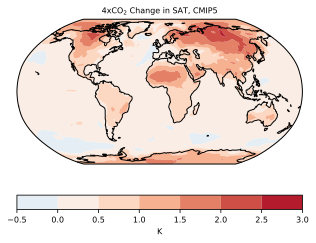

In [6]:
colors_neg = plt.cm.RdBu_r(np.linspace(0.4, 0.5, 256))
colors_pos = plt.cm.RdBu_r(np.linspace(0.5, 1, 256))
all_colors = np.vstack((colors_neg,colors_pos))
orig = colors.LinearSegmentedColormap.from_list('orig',
    all_colors)
divnorm = colors.DivergingNorm(vmin=-0.5, vcenter=0, vmax=3.5)

fig = plt.figure(figsize=(4.5,3.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()

im = ax.contourf(wrap_lon, to_plot.lat, wrap_data,
                transform=ccrs.PlateCarree(),
           cmap=orig,norm=divnorm,levels=np.arange(-0.5,3.5,0.5))

cb = fig.colorbar(im,orientation='horizontal')

cb.ax.tick_params(labelsize=8)
cb.set_label('K',fontsize=8)

ax.set_title(r'4xCO$_2$ Change in SAT, CMIP5',fontsize=8)

plt.tight_layout()
# plt.savefig('spatial_change_SAT_last_30_yrs_061320.pdf')
plt.show()

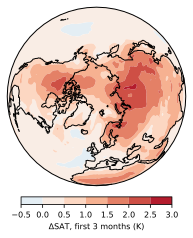

In [8]:
colors_neg = plt.cm.RdBu_r(np.linspace(0.4, 0.5, 256))
colors_pos = plt.cm.RdBu_r(np.linspace(0.5, 1, 256))
all_colors = np.vstack((colors_neg,colors_pos))
orig = colors.LinearSegmentedColormap.from_list('orig',
    all_colors)
divnorm = colors.DivergingNorm(vmin=-0.5, vcenter=0, vmax=3.5)

fig = plt.figure(figsize=(4.5,3.5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines()

im = ax.contourf(wrap_lon, to_plot.lat, wrap_data,
                transform=ccrs.PlateCarree(),
           cmap=orig,norm=divnorm,levels=np.arange(-0.5,3.5,0.5))

# Now adding the colorbar
cb = fig.colorbar(im,orientation='horizontal',shrink=0.5,pad=0.05)

cb.ax.tick_params(labelsize=8)
cb.set_label('ΔSAT, first 3 months (K)',fontsize=8)

# ax.set_title(r'4xCO$_2$ Change in SAT, CMIP5',fontsize=8)

plt.tight_layout(w_pad=0.05)
plt.savefig('spatial_change_SAT_3mon_080620.pdf',bbox_inches='tight')
# plt.show()